# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Mohamad Adi Taufik Hidayat
- **Email:** aditaufik20@gmail.com
- **ID Dicoding:** Mohamad Adi Taufik Hidayat

## Import Semua Packages/Library yang Digunakan

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Hubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path untuk menyimpan dataset
dataset_path = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification"
os.makedirs(dataset_path, exist_ok=True)

# Cek apakah dataset sudah ada
if not os.path.exists(os.path.join(dataset_path, "seg_train")):
    print("Dataset belum ada. Mengunduh dari Kaggle...")

    # Setup Kaggle API
    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp /content/drive/MyDrive/Dicoding/BPML/kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download dataset
    !kaggle datasets download -d puneet6060/intel-image-classification -p {dataset_path}

    # Ekstrak dataset
    !unzip -qo $(find {dataset_path} -name '*.zip') -d {dataset_path}

    print("Download dan ekstraksi selesai!")
else:
    print("Dataset sudah tersedia. Tidak perlu mengunduh ulang.")

# Cek struktur folder
!ls {dataset_path}

Dataset sudah tersedia. Tidak perlu mengunduh ulang.
intel-image-classification.zip	seg_pred  seg_test  seg_train


### Data Preprocessing

#### Split Dataset

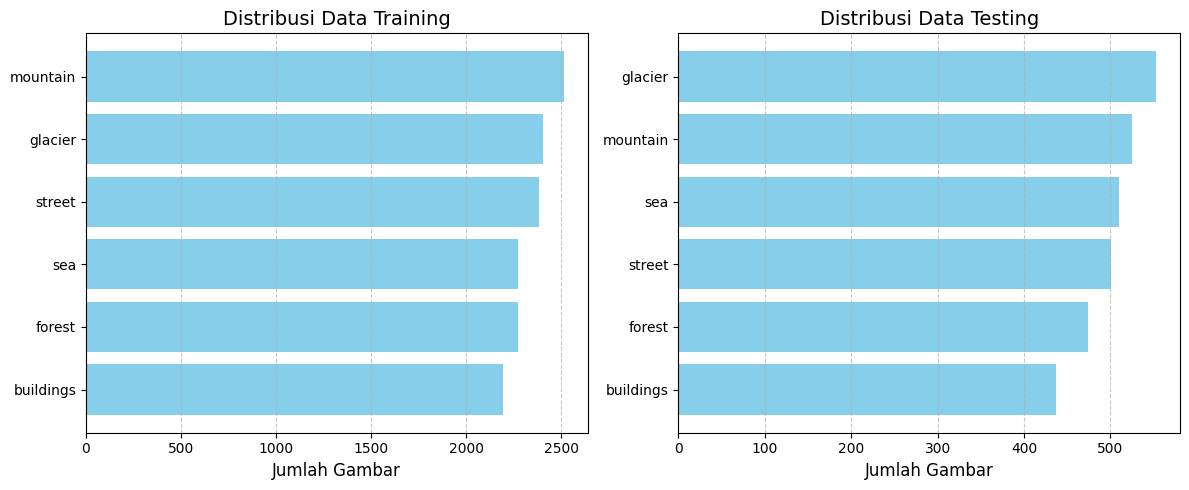

In [5]:
# Path ke dataset
dataset_path = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification"

train_path = os.path.join(dataset_path, "seg_train/seg_train")
test_path = os.path.join(dataset_path, "seg_test/seg_test")

# Fungsi untuk menghitung jumlah gambar di setiap kelas
def count_images_in_folders(base_path):
    class_counts = {}
    for class_name in os.listdir(base_path):
        class_folder = os.path.join(base_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Hitung jumlah gambar per kelas
train_counts = count_images_in_folders(train_path)
test_counts = count_images_in_folders(test_path)

# Plot distribusi dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Hanya train dan test

def plot_distribution(ax, data, title):
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=True))  # Urutkan dari terbesar
    ax.barh(list(sorted_data.keys()), list(sorted_data.values()), color='skyblue')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Jumlah Gambar", fontsize=12)
    ax.invert_yaxis()  # kategori dengan jumlah terbanyak ada di atas
    ax.grid(axis="x", linestyle="--", alpha=0.7)

plot_distribution(axes[0], train_counts, "Distribusi Data Training")
plot_distribution(axes[1], test_counts, "Distribusi Data Testing")

plt.tight_layout()
plt.show()


In [6]:
# Path dataset
train_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_test/seg_test"

# Fungsi untuk menghitung jumlah gambar di setiap kategori
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Hitung jumlah gambar per kategori
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Tampilkan hasil
print("Jumlah gambar per kategori (Train):", train_counts)
print("Jumlah gambar per kategori (Test):", test_counts)


Jumlah gambar per kategori (Train): {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
Jumlah gambar per kategori (Test): {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


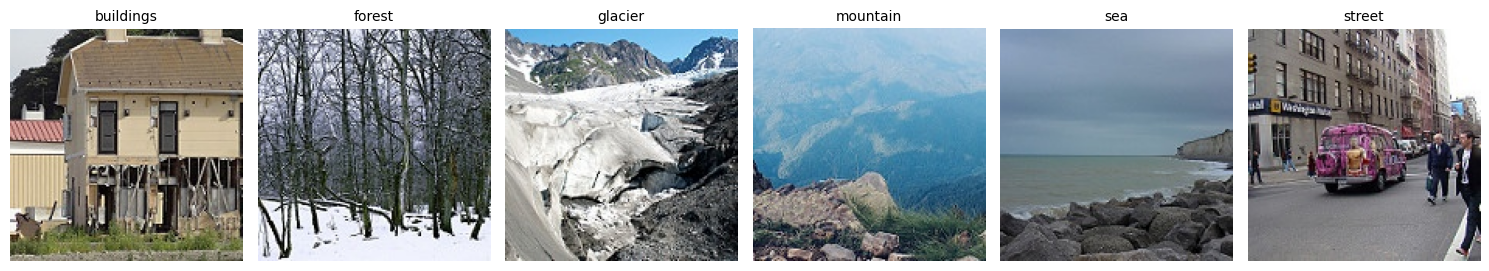

In [7]:
# Path ke dataset
dataset_path = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_train"
train_path = os.path.join(dataset_path, "seg_train")

# Ambil daftar kelas dalam dataset
class_names = sorted(os.listdir(train_path))

# Buat plot untuk menampilkan contoh gambar dari tiap kategori
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    sample_image = random.choice(os.listdir(class_folder))  # Pilih satu gambar acak
    img_path = os.path.join(class_folder, sample_image)

    img = load_img(img_path, target_size=(150, 150))  # Resize gambar jika perlu
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [12]:
# Path ke folder dataset
train_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_test/seg_test"

# ImageDataGenerator untuk training dan validation dengan pembagian otomatis (80% train, 20% valid)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Data training (80%)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,  # sesuaikan batch size
    class_mode='categorical',
    subset='training'  # Untuk training set
)

# Data validation (20%)
valid_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,  # sesuaikan batch size
    class_mode='categorical',
    subset='validation'  # Untuk validation set
)

# Data testing (test set tidak perlu split karena sudah terpisah)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,  # sesuaikan batch size
    class_mode='categorical',
    shuffle=False
)

# Cek jumlah sample
print(f"Total training images: {train_generator.samples}")
print(f"Total validation images: {valid_generator.samples}")
print(f"Total testing images: {test_generator.samples}")


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Total training images: 11230
Total validation images: 2804
Total testing images: 3000


## Modelling CNN

In [13]:
# **Model CNN**
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Mencegah overfitting
    Dense(6, activation='softmax')  # 6 kelas output
])

# **Compile Model CNN**
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,830,022 (18.43 MB)

 Trainable params: 4,829,574 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# Callback untuk menyimpan model terbaik dari CNN
cnn_model_checkpoint = ModelCheckpoint(
    'cnn_best_model.h5',  # Simpan model CNN ke file ini
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Berhenti hanya jika accuracy dan val_accuracy mencapai 95% atau lebih
class CNNCustomStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nAkurasi training & validasi mencapai 95%. Menghentikan training CNN!")
            self.model.stop_training = True

cnn_custom_stopping = CNNCustomStopping()


cnn_history = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[cnn_model_checkpoint, cnn_custom_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4821 - loss: 4.2593
Epoch 1: val_accuracy improved from -inf to 0.34165, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.4823 - loss: 4.2541 - val_accuracy: 0.3417 - val_loss: 8.1961
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6127 - loss: 1.5378
Epoch 2: val_accuracy did not improve from 0.34165
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 334ms/step - accuracy: 0.6127 - loss: 1.5377 - val_accuracy: 0.2443 - val_loss: 9.4997
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6679 - loss: 1.0886
Epoch 3: val_accuracy improved from 0.34165 to 0.61234, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 331ms/step - accuracy: 0.6679 - loss: 1.0882 - val_accuracy: 0.6123 - val_loss: 1.4388
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7221 - loss: 0.8057
Epoch 4: val_accuracy improved from 0.61234 to 0.75820, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 332ms/step - accuracy: 0.7221 - loss: 0.8056 - val_accuracy: 0.7582 - val_loss: 0.8558
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7548 - loss: 0.6819
Epoch 5: val_accuracy improved from 0.75820 to 0.76641, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - accuracy: 0.7548 - loss: 0.6819 - val_accuracy: 0.7664 - val_loss: 0.7247
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7859 - loss: 0.5977
Epoch 6: val_accuracy improved from 0.76641 to 0.77817, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 342ms/step - accuracy: 0.7859 - loss: 0.5977 - val_accuracy: 0.7782 - val_loss: 0.6714
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8049 - loss: 0.5204
Epoch 7: val_accuracy did not improve from 0.77817
176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 331ms/step - accuracy: 0.8049 - loss: 0.5206 - val_accuracy: 0.6680 - val_loss: 1.3904
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8170 - loss: 0.4917
Epoch 8: val_accuracy did not improve from 0.77817
176/176 ━━━━━━━━━━━━━━━━━━━━ 68s 386ms/step - accuracy: 0.8170 - loss: 0.4918 - val_accuracy: 0.6006 - val_loss: 1.9590
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8180 - loss: 0.5100
Epoch 9: val_accuracy did not improve from 0.77817
176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 340ms/step - accuracy: 0.8181 - loss: 0.5099 - val_accuracy: 0.7536 - val_loss: 0.8360
Epoch 10/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8412 - loss: 0.4204
Epoch 10: val_

176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 321ms/step - accuracy: 0.8567 - loss: 0.3861 - val_accuracy: 0.7910 - val_loss: 0.7690
Epoch 12/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8766 - loss: 0.3526
Epoch 12: val_accuracy improved from 0.79101 to 0.79957, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 311ms/step - accuracy: 0.8766 - loss: 0.3526 - val_accuracy: 0.7996 - val_loss: 0.7891
Epoch 13/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8922 - loss: 0.3024
Epoch 13: val_accuracy did not improve from 0.79957
176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 323ms/step - accuracy: 0.8922 - loss: 0.3025 - val_accuracy: 0.7760 - val_loss: 0.7421
Epoch 14/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8912 - loss: 0.2930
Epoch 14: val_accuracy improved from 0.79957 to 0.81384, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - accuracy: 0.8912 - loss: 0.2930 - val_accuracy: 0.8138 - val_loss: 0.7675
Epoch 15/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9047 - loss: 0.2597
Epoch 15: val_accuracy did not improve from 0.81384
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 307ms/step - accuracy: 0.9047 - loss: 0.2597 - val_accuracy: 0.7860 - val_loss: 0.9080
Epoch 16/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9145 - loss: 0.2416
Epoch 16: val_accuracy did not improve from 0.81384
176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 363ms/step - accuracy: 0.9145 - loss: 0.2416 - val_accuracy: 0.8106 - val_loss: 0.7037
Epoch 17/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9224 - loss: 0.2248
Epoch 17: val_accuracy improved from 0.81384 to 0.82525, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 313ms/step - accuracy: 0.9223 - loss: 0.2249 - val_accuracy: 0.8252 - val_loss: 0.7987
Epoch 18/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9251 - loss: 0.2122
Epoch 18: val_accuracy did not improve from 0.82525
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - accuracy: 0.9251 - loss: 0.2121 - val_accuracy: 0.7785 - val_loss: 0.9937
Epoch 19/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9309 - loss: 0.1866
Epoch 19: val_accuracy did not improve from 0.82525
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 306ms/step - accuracy: 0.9309 - loss: 0.1867 - val_accuracy: 0.7946 - val_loss: 0.7183
Epoch 20/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9298 - loss: 0.2006
Epoch 20: val_accuracy did not improve from 0.82525
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 309ms/step - accuracy: 0.9297 - loss: 0.2007 - val_accuracy: 0.8174 - val_loss: 0.8881
Epoch 21/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9241 - loss: 0.2118
Epoch 21

176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step - accuracy: 0.9423 - loss: 0.1713 - val_accuracy: 0.8267 - val_loss: 0.6842
Epoch 23/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9395 - loss: 0.1604
Epoch 23: val_accuracy improved from 0.82668 to 0.83488, saving model to cnn_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 307ms/step - accuracy: 0.9395 - loss: 0.1605 - val_accuracy: 0.8349 - val_loss: 0.7550
Epoch 24/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9452 - loss: 0.1428
Epoch 24: val_accuracy did not improve from 0.83488
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 307ms/step - accuracy: 0.9452 - loss: 0.1429 - val_accuracy: 0.8146 - val_loss: 0.9443
Epoch 25/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9429 - loss: 0.1626
Epoch 25: val_accuracy did not improve from 0.83488
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 310ms/step - accuracy: 0.9429 - loss: 0.1627 - val_accuracy: 0.7368 - val_loss: 1.3974
Epoch 26/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9456 - loss: 0.1517
Epoch 26: val_accuracy did not improve from 0.83488
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 309ms/step - accuracy: 0.9456 - loss: 0.1517 - val_accuracy: 0.8281 - val_loss: 1.0041
Epoch 27/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9527 - loss: 0.1419
Epoch 27

## Evaluasi dan Visualisasi CNN

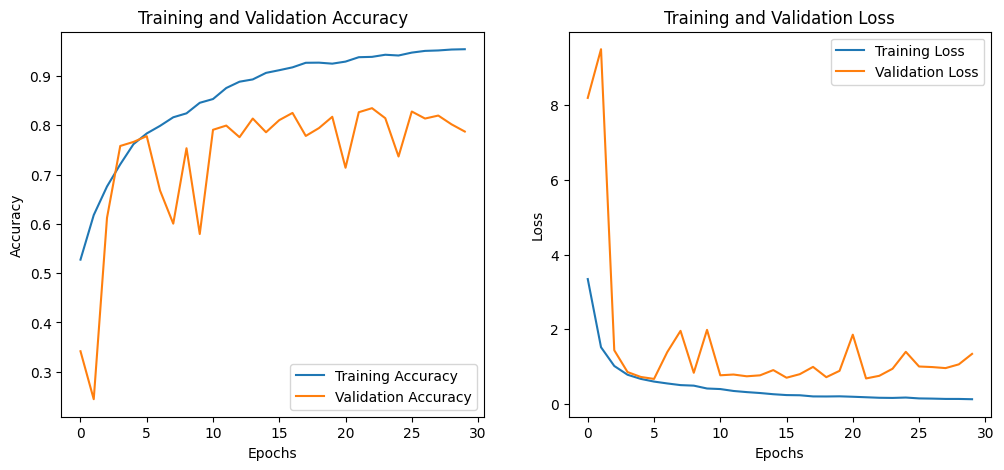

In [15]:
# Plot hasil training
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

Found 3000 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


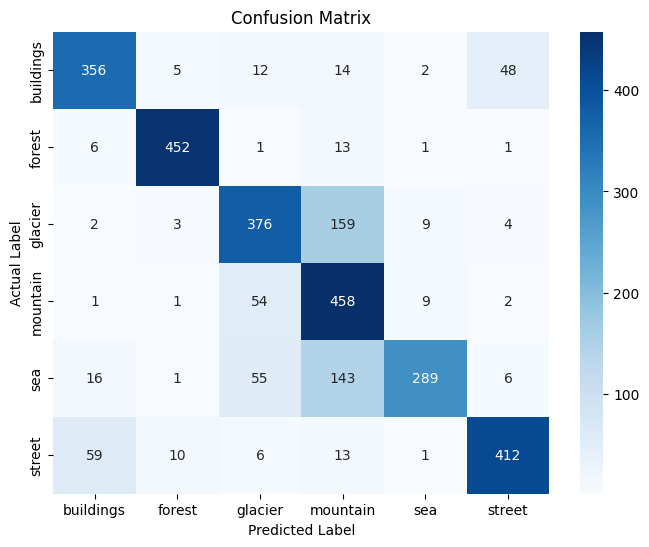


Classification Report:

              precision    recall  f1-score   support

   buildings     0.8091    0.8146    0.8119       437
      forest     0.9576    0.9536    0.9556       474
     glacier     0.7460    0.6799    0.7114       553
    mountain     0.5725    0.8724    0.6913       525
         sea     0.9293    0.5667    0.7040       510
      street     0.8710    0.8224    0.8460       501

    accuracy                         0.7810      3000
   macro avg     0.8143    0.7849    0.7867      3000
weighted avg     0.8103    0.7810    0.7823      3000



In [17]:
cnn_test_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_test/seg_test"

# Buat test generator
cnn_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

cnn_test_generator = cnn_test_datagen.flow_from_directory(
    cnn_test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Reset generator sebelum prediksi
cnn_test_generator.reset()

# Lakukan prediksi
cnn_preds = cnn_model.predict(cnn_test_generator, verbose=0)

# Ubah prediksi ke format kategori (argmax untuk kelas tertinggi)
cnn_preds_class = np.argmax(cnn_preds, axis=1)

# Confusion Matrix
cnn_cm = confusion_matrix(cnn_test_generator.classes, cnn_preds_class)
cnn_cm_df = pd.DataFrame(cnn_cm, index=cnn_test_generator.class_indices.keys(), columns=cnn_test_generator.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cnn_cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true=cnn_test_generator.classes,
    y_pred=cnn_preds_class,
    target_names=cnn_test_generator.class_indices.keys(),
    digits=4
))

##Modelling MobileNetV2

In [8]:
# Path ke dataset
mobilenet_train_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_train/seg_train"
mobilenet_test_dir = "/content/drive/MyDrive/Dicoding/BPML/Datasets/intel-image-classification/seg_test/seg_test"

# ImageDataGenerator
mobilenet_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train data (80%)
mobilenet_train_generator = mobilenet_datagen.flow_from_directory(
    mobilenet_train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

# Validation data (20%)
mobilenet_valid_generator = mobilenet_datagen.flow_from_directory(
    mobilenet_train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

# Test data
mobilenet_test_datagen = ImageDataGenerator(rescale=1./255)
mobilenet_test_generator = mobilenet_test_datagen.flow_from_directory(
    mobilenet_test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Load MobileNetV2
mobilenet_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Freeze semua layer agar hanya bagian atas yang dilatih
mobilenet_base_model.trainable = False

# Tambahkan lapisan tambahan
mobilenet_x = mobilenet_base_model.output
mobilenet_x = Conv2D(64, (3,3), activation='relu', padding='same')(mobilenet_x)  # Lapisan Conv2D tambahan
mobilenet_x = GlobalAveragePooling2D()(mobilenet_x)
mobilenet_x = Dense(128, activation='relu')(mobilenet_x)
mobilenet_x = Dropout(0.5)(mobilenet_x)
mobilenet_x = Dense(mobilenet_train_generator.num_classes, activation='softmax')(mobilenet_x)  # Output layer

# Buat model baru
mobilenet_model = Model(inputs=mobilenet_base_model.input, outputs=mobilenet_x)

# Compile model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Train model
mobilenet_history = mobilenet_model.fit(
    mobilenet_train_generator,
    epochs=30,
    validation_data=mobilenet_valid_generator)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


<ipython-input-8-bdcbd62541da>:37: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 408ms/step - accuracy: 0.6729 - loss: 0.8817 - val_accuracy: 0.8991 - val_loss: 0.2942
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 314ms/step - accuracy: 0.8715 - loss: 0.3595 - val_accuracy: 0.9026 - val_loss: 0.2697
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 313ms/step - accuracy: 0.8990 - loss: 0.2945 - val_accuracy: 0.8962 - val_loss: 0.2882
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 318ms/step - accuracy: 0.9079 - loss: 0.2667 - val_accuracy: 0.9055 - val_loss: 0.2623
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 368ms/step - accuracy: 0.9129 - loss: 0.2477 - val_accuracy: 0.9005 - val_loss: 0.2696
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 315ms/step - accuracy: 0.9210 - loss: 0.2271 - val_accuracy: 0.9016 - val_loss: 0.2637
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 311ms/step - accuracy: 0.9304 - loss: 0.1974 - val_accuracy: 0.9034 - val_loss: 0.2673
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 367ms/step - accuracy: 0.9337 - loss: 0

## Evaluasi dan Visualisasi MobileNetV2

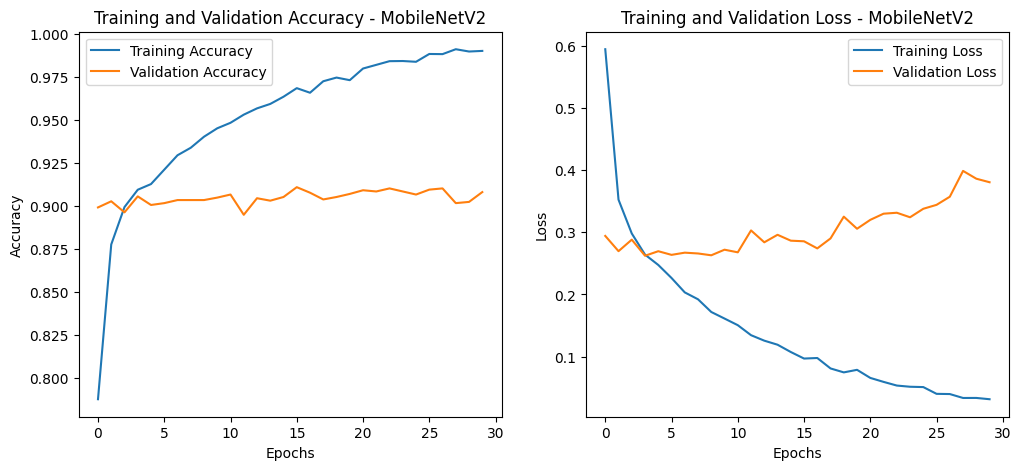

In [9]:
# Plot hasil training untuk MobileNetV2
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy - MobileNetV2')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], label='Training Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss - MobileNetV2')

plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step


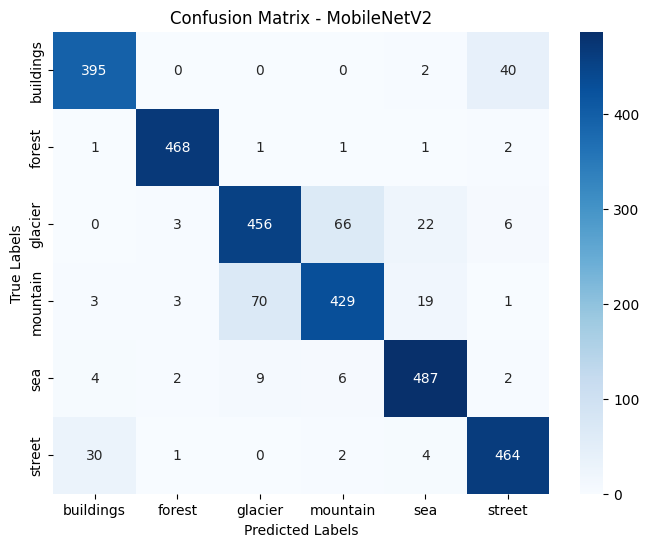


Classification Report:

              precision    recall  f1-score   support

   buildings     0.9122    0.9039    0.9080       437
      forest     0.9811    0.9873    0.9842       474
     glacier     0.8507    0.8246    0.8375       553
    mountain     0.8512    0.8171    0.8338       525
         sea     0.9103    0.9549    0.9321       510
      street     0.9010    0.9261    0.9134       501

    accuracy                         0.8997      3000
   macro avg     0.9011    0.9023    0.9015      3000
weighted avg     0.8989    0.8997    0.8991      3000



In [10]:
# Reset test generator
mobilenet_test_generator.reset()

# Prediksi dengan model MobileNetV2
mobilenet_preds = mobilenet_model.predict(mobilenet_test_generator, verbose=1)
mobilenet_predictions = np.argmax(mobilenet_preds, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Ambil label asli
mobilenet_true_labels = mobilenet_test_generator.classes
mobilenet_class_labels = list(mobilenet_test_generator.class_indices.keys())  # Nama kelas

# **Confusion Matrix**
mobilenet_cm = confusion_matrix(mobilenet_true_labels, mobilenet_predictions)
mobilenet_cm_df = pd.DataFrame(mobilenet_cm, index=mobilenet_class_labels, columns=mobilenet_class_labels)

plt.figure(figsize=(8,6))
sns.heatmap(mobilenet_cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

# **Classification Report**
print("\nClassification Report:\n")
print(classification_report(mobilenet_true_labels, mobilenet_predictions, target_names=mobilenet_class_labels, digits=4))

## Konversi Model

In [11]:
# Simpan model
mobilenet_model.save("/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_model.h5")

In [13]:
# Simpan model dalam format SavedModel
mobilenet_model.export("/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_saved_model", save_format="tf")

Saved artifact at '/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135374445857872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445858832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445862096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445861712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445860560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445862288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445861328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445858640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445862480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135374445859984: TensorSpec(s

In [18]:
import tensorflow as tf

# Path untuk menyimpan model TFLite
tflite_model_path = "/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_model.tflite"

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_saved_model")
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("Konversi ke TFLite selesai. Model disimpan di:", tflite_model_path)

Konversi ke TFLite selesai. Model disimpan di: /content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_model.tflite


In [20]:
# Path penyimpanan model dan label
tflite_dir = "/content/drive/MyDrive/Dicoding/BPML/Submission"
tflite_model_path = os.path.join(tflite_dir, "mobilenetv2_model.tflite")
label_path = os.path.join(tflite_dir, "label.txt")

# Pastikan folder tujuan ada
os.makedirs(tflite_dir, exist_ok=True)

# **1. Konversi Model ke TFLite**
# Load model dari SavedModel format
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_saved_model")

# Konversi ke TFLite
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("✅ Konversi ke TFLite selesai. Model disimpan di:", tflite_model_path)

# **2. Simpan Label ke label.txt**
# Ambil daftar label dari test generator (Pastikan variabel benar)
labels = list(mobilenet_test_generator.class_indices.keys())

# Simpan label ke file label.txt
with open(label_path, "w") as f:
    for label in labels:
        f.write(label + "\n")

print("✅ Label disimpan di:", label_path)


✅ Konversi ke TFLite selesai. Model disimpan di: /content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_model.tflite
✅ Label disimpan di: /content/drive/MyDrive/Dicoding/BPML/Submission/label.txt


In [26]:
!pip install tensorflowjs

In [4]:
import tensorflowjs as tfjs

# Path model .h5 yang telah disimpan
h5_model_path = "/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_model.h5"

# Path output untuk model TFJS
tfjs_output_dir = "/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_tfjs/"

# Konversi ke format TensorFlow.js
tfjs.converters.save_keras_model(tf.keras.models.load_model(h5_model_path), tfjs_output_dir)

print(f"✅ Konversi selesai! Model TFJS disimpan di: {tfjs_output_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
✅ Konversi selesai! Model TFJS disimpan di: /content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_tfjs/


## Inference (Optional)

Saving 5.jpg to 5 (2).jpg


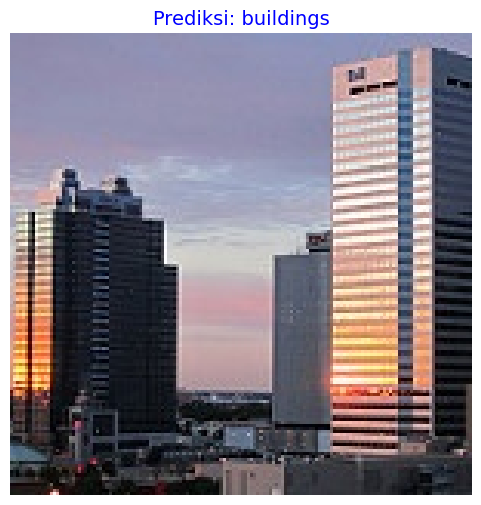

Prediksi kelas untuk 5 (2).jpg: buildings


In [24]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# Path model TFLite dan label
tflite_model_path = "/content/drive/MyDrive/Dicoding/BPML/Submission/mobilenetv2_model.tflite"
label_path = "/content/drive/MyDrive/Dicoding/BPML/Submission/label.txt"

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil indeks input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label dari file label.txt
with open(label_path, "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Upload gambar
uploaded = files.upload()

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (150, 150))
    img_resized = img_resized.astype(np.float32) / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    # Jalankan inference
    interpreter.set_tensor(input_details[0]['index'], img_resized)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Prediksi kelas
    predicted_class_idx = np.argmax(output_data)
    predicted_class = labels[predicted_class_idx]  # Ambil label dari file

    # Tampilkan gambar dan prediksi
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Prediksi: {predicted_class}", fontsize=14, color='blue')
    plt.show()

    print(f"Prediksi kelas untuk {filename}: {predicted_class}")

In [5]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=12927584f708f2d9e9e477ba1053005c37e030019997405b72341a0ae41a51af
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [6]:
!pipreqs "/content/drive/MyDrive/Dicoding/BPML/Submission" --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Dicoding/BPML/Submission/requirements.txt
